In [1]:
%matplotlib notebook
DEFAULT_FIGSIZE = (8, 6)
#%matplotlib inline 
#DEFAULT_FIGSIZE = (12, 8)

import numpy as np
import scipy.signal
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from dtk.bicycle import benchmark_state_space_vs_speed, benchmark_matrices
import control

import plot_sim as ps

from phobos import sysid

%load_ext autoreload
%autoreload 2

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = DEFAULT_FIGSIZE

length 50
frequencies 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.2, 2.4, 2.6, 2.8, 3.0, 3.2, 3.4, 3.6, 3.8, 4.0, 4.2, 4.4, 4.6, 4.8, 5.0, 5.2, 5.4, 5.6, 5.8, 6.0, 6.2, 6.4, 6.6, 6.8, 7.0, 7.2, 7.4, 7.6, 7.8, 8.0, 8.2, 8.4, 8.6, 8.8, 9.0, 9.2, 9.4, 9.6, 9.8, 10.0
rs sequence 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0


<IPython.core.display.Javascript object>


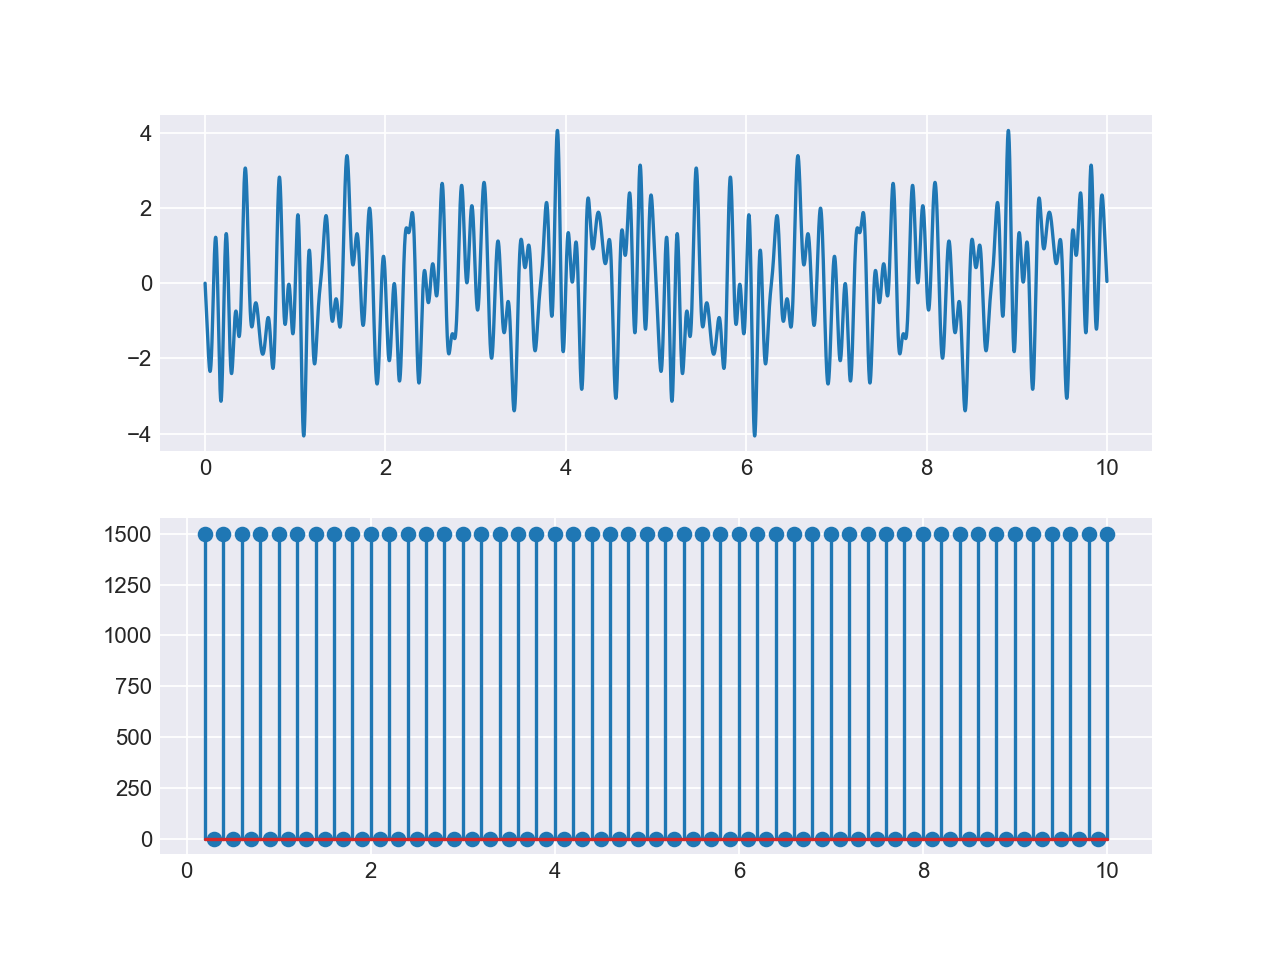

In [146]:
plt.close('all')

t = np.arange(0, 10, 0.001)
dt = 0.001
n = int(10/dt)

def multisine(frequencies):
    n = len(frequencies)
    seq = np.array(sysid.rudin_shapiro(n) > 0).astype(float)
    print('length', n)
    print('frequencies', ', '.join(str(f) for f in frequencies))
    print('rs sequence', ', '.join(str(s) for s in seq))
    
    u = np.zeros(t.shape)
    amplitude = 0.3
    for f, s in zip(frequencies, seq):
        period = 1/f
        u += amplitude*np.sin(2*np.pi*f*t + s*np.pi)
    return u

# we use these later
u_freq = np.arange(0.2, 10.2, 0.2)
u = multisine(u_freq)

x = np.fft.rfft(u)
freq = np.fft.rfftfreq(len(u), dt)
index = (freq >= min(u_freq)) & (freq <= max(u_freq))

fig, ax = plt.subplots(2, 1)
ax[0].plot(t, u)
ax[1].stem(freq[index], np.abs(x[index]))
plt.show()

In [3]:
# simulate model response to multisine 'u'
_, A, B = benchmark_state_space_vs_speed(*benchmark_matrices(), [5])
A = A[0]
B = B[0]
Bi = B[:, [1]] # steer torque
Ci = np.array([[0, 1, 0, 0]]) # steer angle
D = np.array([[0]])

sys = scipy.signal.StateSpace(A, Bi, Ci, D)
tf = scipy.signal.TransferFunction(sys)

# simulate for 20 seconds
lsim_t = np.arange(0, 20, dt)
lsim_u = np.concatenate((u, u))
_, lsim_y, lsim_x = scipy.signal.lsim(sys, lsim_u, lsim_t)

/Users/oliver/miniconda3/envs/dev/lib/python3.5/site-packages/scipy/signal/filter_design.py:1452: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  "results may be meaningless", BadCoefficients)


In [2]:
log1 = ps.ProcessedRecord('logs/multisine.pb.cobs.gz')
log2 = ps.ProcessedRecord('logs/multisine_kp150_kd3.pb.cobs.gz')
log3 = ps.ProcessedRecord('logs/multisine_kp20_kd2.pb.cobs.gz')
logs = [log1, log2, log3]

In [5]:
def plot_response(log ):
    t = log.t
    u = sysid._get_signal(log, 'u')
    u1 = sysid._get_signal(log, 'u1')
    u2 = sysid._get_signal(log, 'u2')
    r = sysid._get_signal(log, 'r')
    y = sysid._get_signal(log, 'y')
    
    fig, ax = plt.subplots(2, 1, sharex=True)
    ax[0].plot(t, u[0], label=u[1])
    ax[0].plot(t, u1[0], label=u1[1])
    ax[0].plot(t, u2[0], label=u2[1])
    ax[0].legend()
    ax[0].set_ylabel('torque [N-m]')
    
    ax[1].plot(t, 180/np.pi * r[0], label=r[1])
    ax[1].plot(t, 180/np.pi * y[0], label=y[1])
    ax[1].legend()
    ax[1].set_ylabel('angle [deg]')
    ax[1].set_xlabel('time [s]')
    return fig, ax

<IPython.core.display.Javascript object>


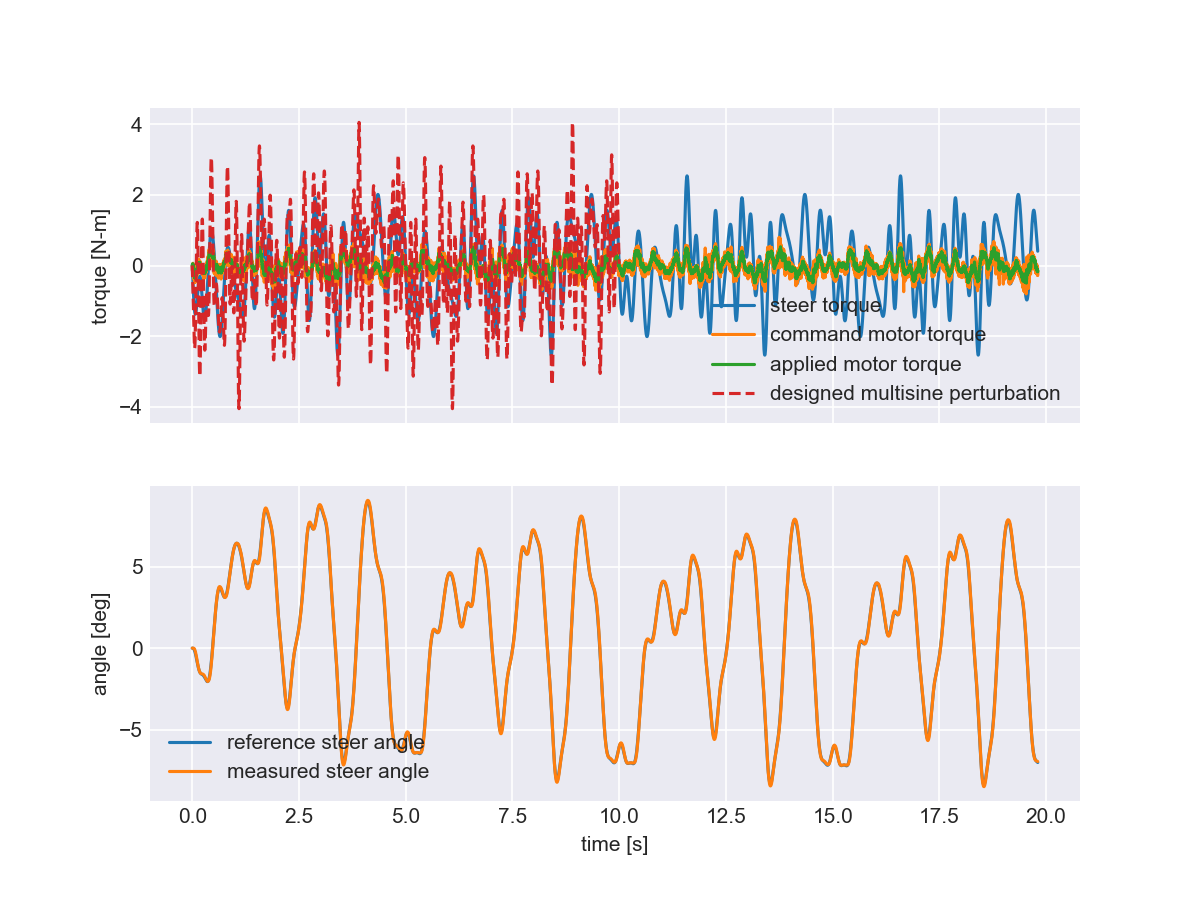

<IPython.core.display.Javascript object>


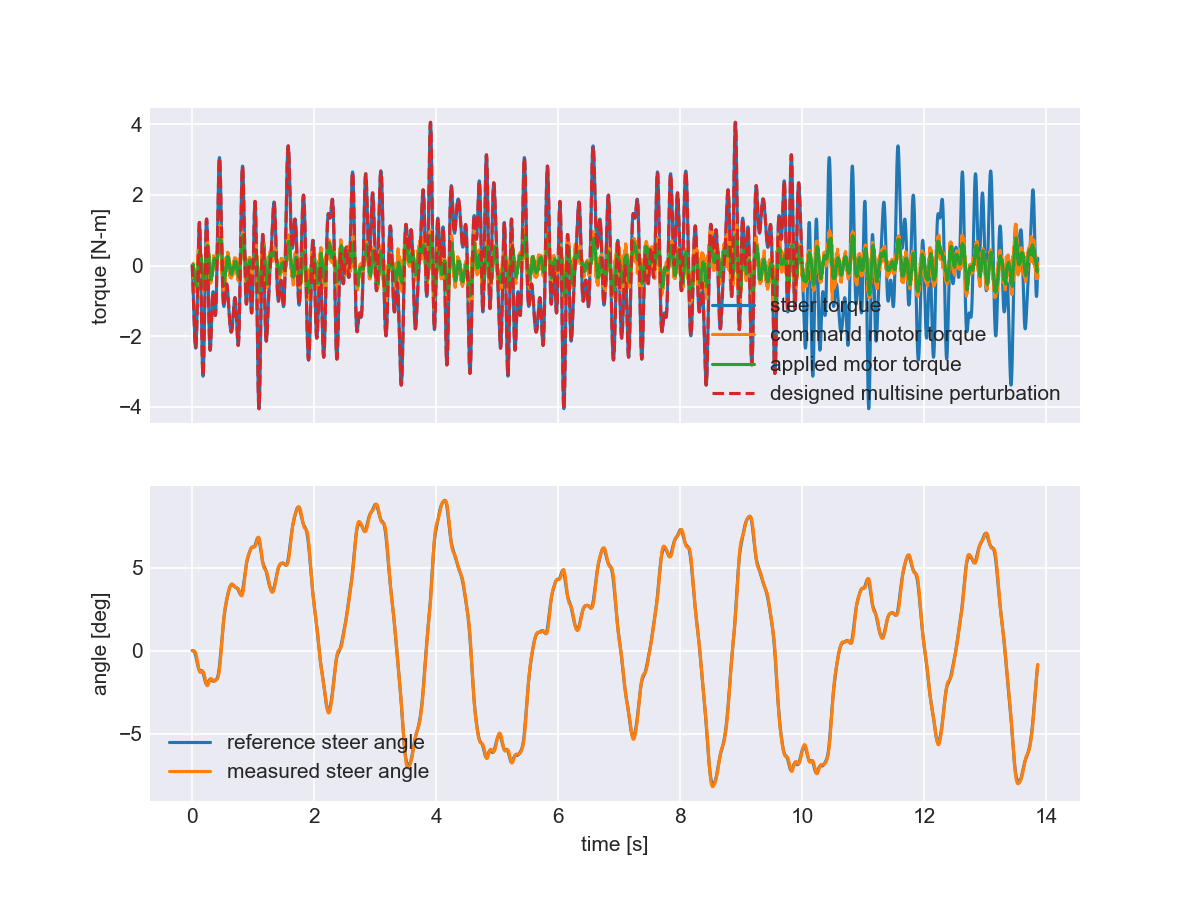

<IPython.core.display.Javascript object>


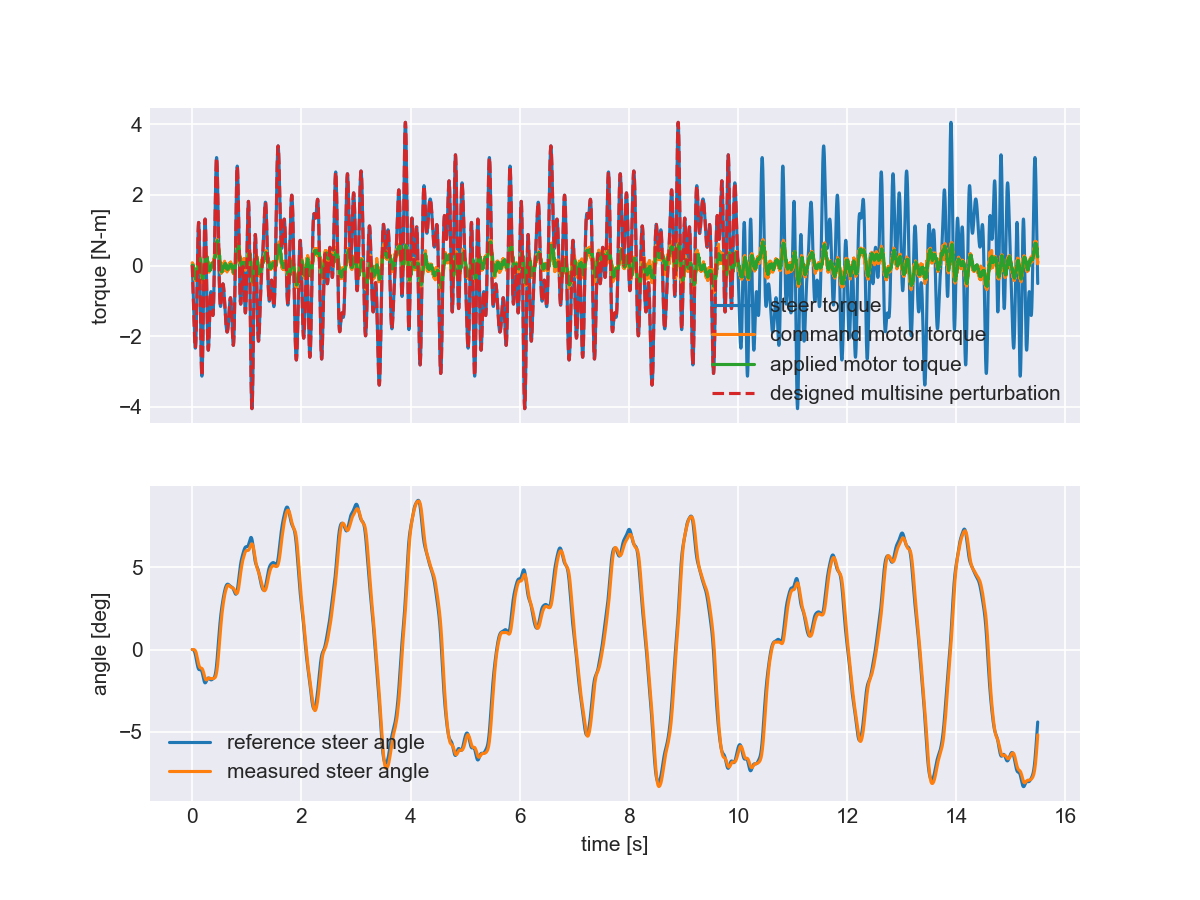

In [6]:
plt.close('all')
for l in logs:
    fig, ax = plot_response(l)
    ax[0].plot(t, u, linestyle='--',
               label='designed multisine perturbation')
    ax[0].legend()
plt.show()

In [7]:
def plot_frequency_response(log, tfio=None, unwrap=True, noverlap=None):
    fig, ax = plt.subplots(3, 1, sharex=True)
    
    if tfio is None: # transfer function input/output list
        tfio = [('u', 'y'), ('r', 'y'), ('u', 'u2')]
        
    skipn = int(1//dt) # skip first second
    window_size = n
    print('window size: {}'.format(window_size))
    
    if noverlap is None:
        noverlap = int(n//10)
    
    nwindows = int((len(log.t) - window_size)//noverlap)
    print('plotting frequency response using {} windows with {} overlap'.format(
        nwindows, noverlap))
    
    index = [i for i, f in enumerate(np.around(freq, 1))
             if f in np.around(u_freq, 1)]
    
    for x, y in tfio:
        frf = sysid.frequency_response(x, y, log, skipn, window_size, noverlap)
        c = sysid.coherence(x, y, log, skipn, window_size, noverlap)
        
        x_label = sysid._get_signal(log, x)[1]
        y_label = sysid._get_signal(log, y)[1]
    
        mag = np.abs(frf[index])
        phase = np.angle(frf[index], deg=True)
        if unwrap:
            phase = np.unwrap(phase, 180)
        label='{}/{}: {} to {}'.format(y.upper(), x.upper(), x_label, y_label)
        
        ax[0].loglog(freq[index], mag, label=label)
        ax[1].semilogx(freq[index], phase, label=label)
        ax[2].semilogx(freq[index], c[index], label=label)
    
    ax[0].set_title('frequency response and coherence ({})'.format(log.basename))
    ax[0].legend()
    ax[0].set_ylabel('gain')
    ax[1].legend()
    ax[1].set_ylabel('phase [deg]')
    ax[2].legend()
    ax[2].set_ylabel('coherence')
    ax[2].set_ylim((0, 1))
    return fig, ax

<IPython.core.display.Javascript object>


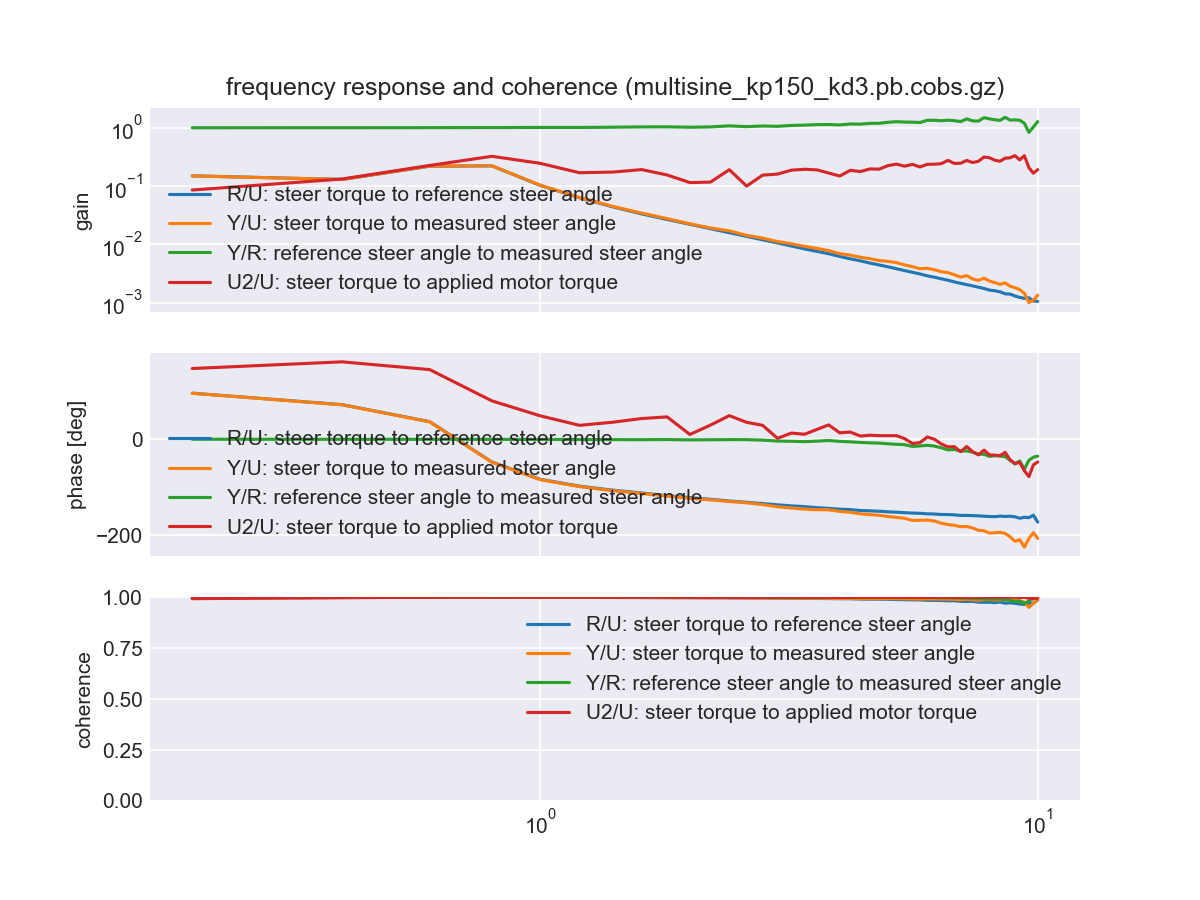

window size: 10000
plotting frequency response using 38 windows with 100 overlap


/Users/oliver/miniconda3/envs/dev/lib/python3.5/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


<IPython.core.display.Javascript object>


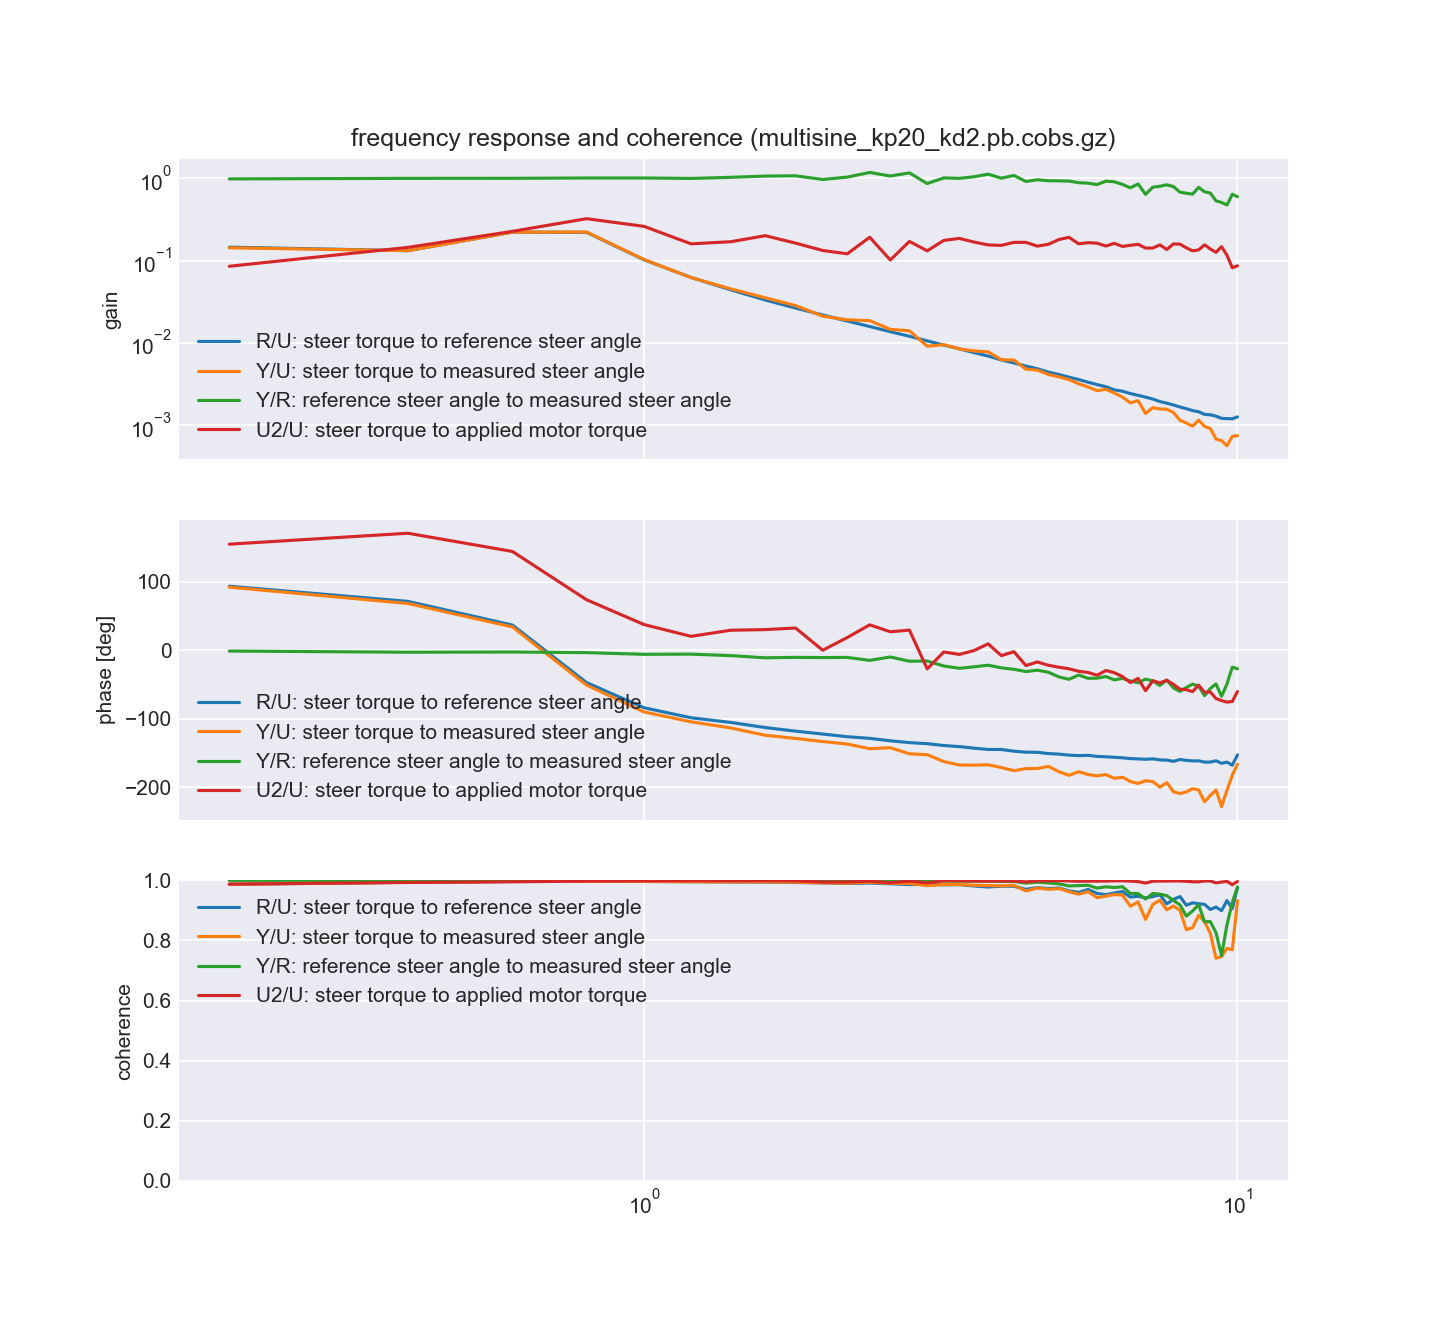

window size: 10000
plotting frequency response using 53 windows with 100 overlap


In [8]:
plt.close('all')
for l in logs[1:]:
    plot_frequency_response(
        l, tfio=[('u', 'r'), ('u', 'y'), ('r', 'y'), ('u', 'u2')],
        unwrap=True, noverlap=100)
plt.show()

<IPython.core.display.Javascript object>


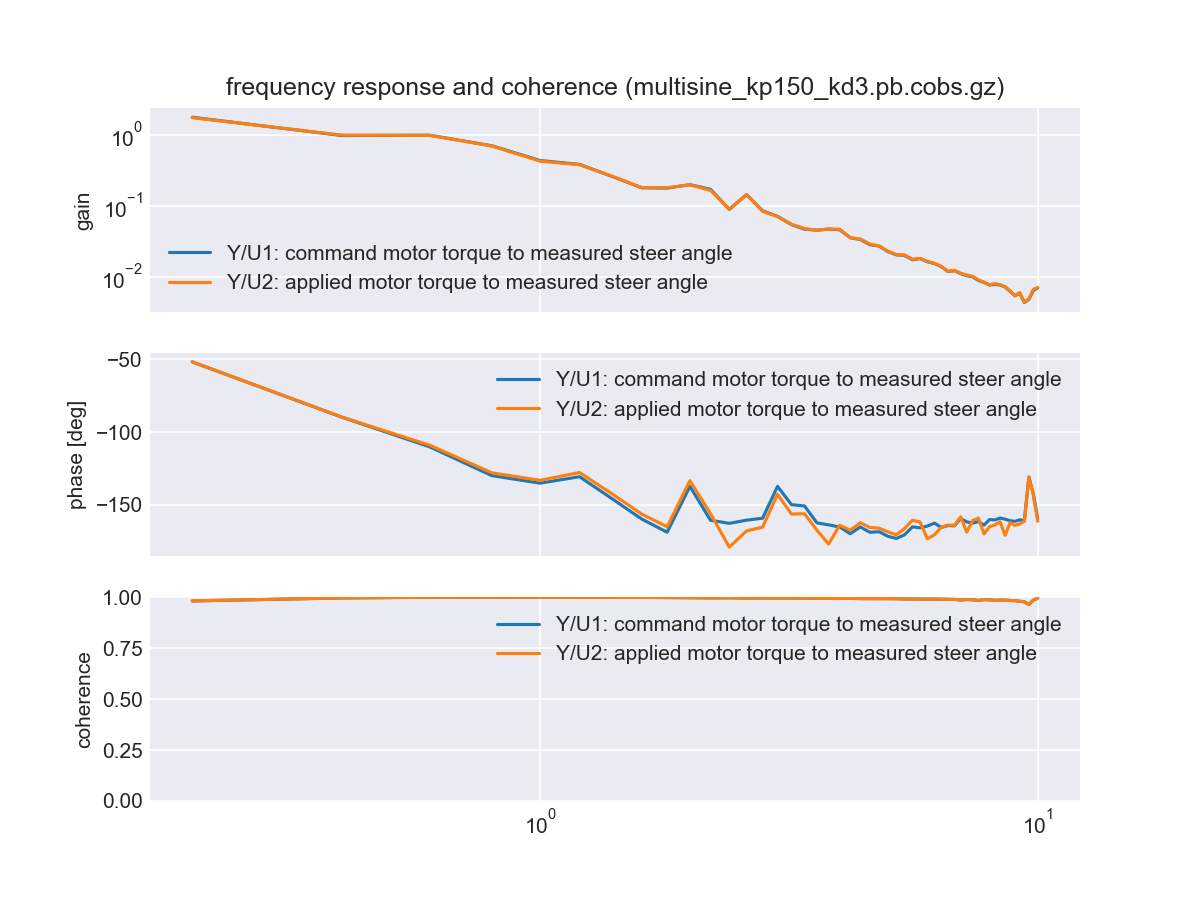

window size: 10000
plotting frequency response using 38 windows with 100 overlap


/Users/oliver/miniconda3/envs/dev/lib/python3.5/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


<IPython.core.display.Javascript object>


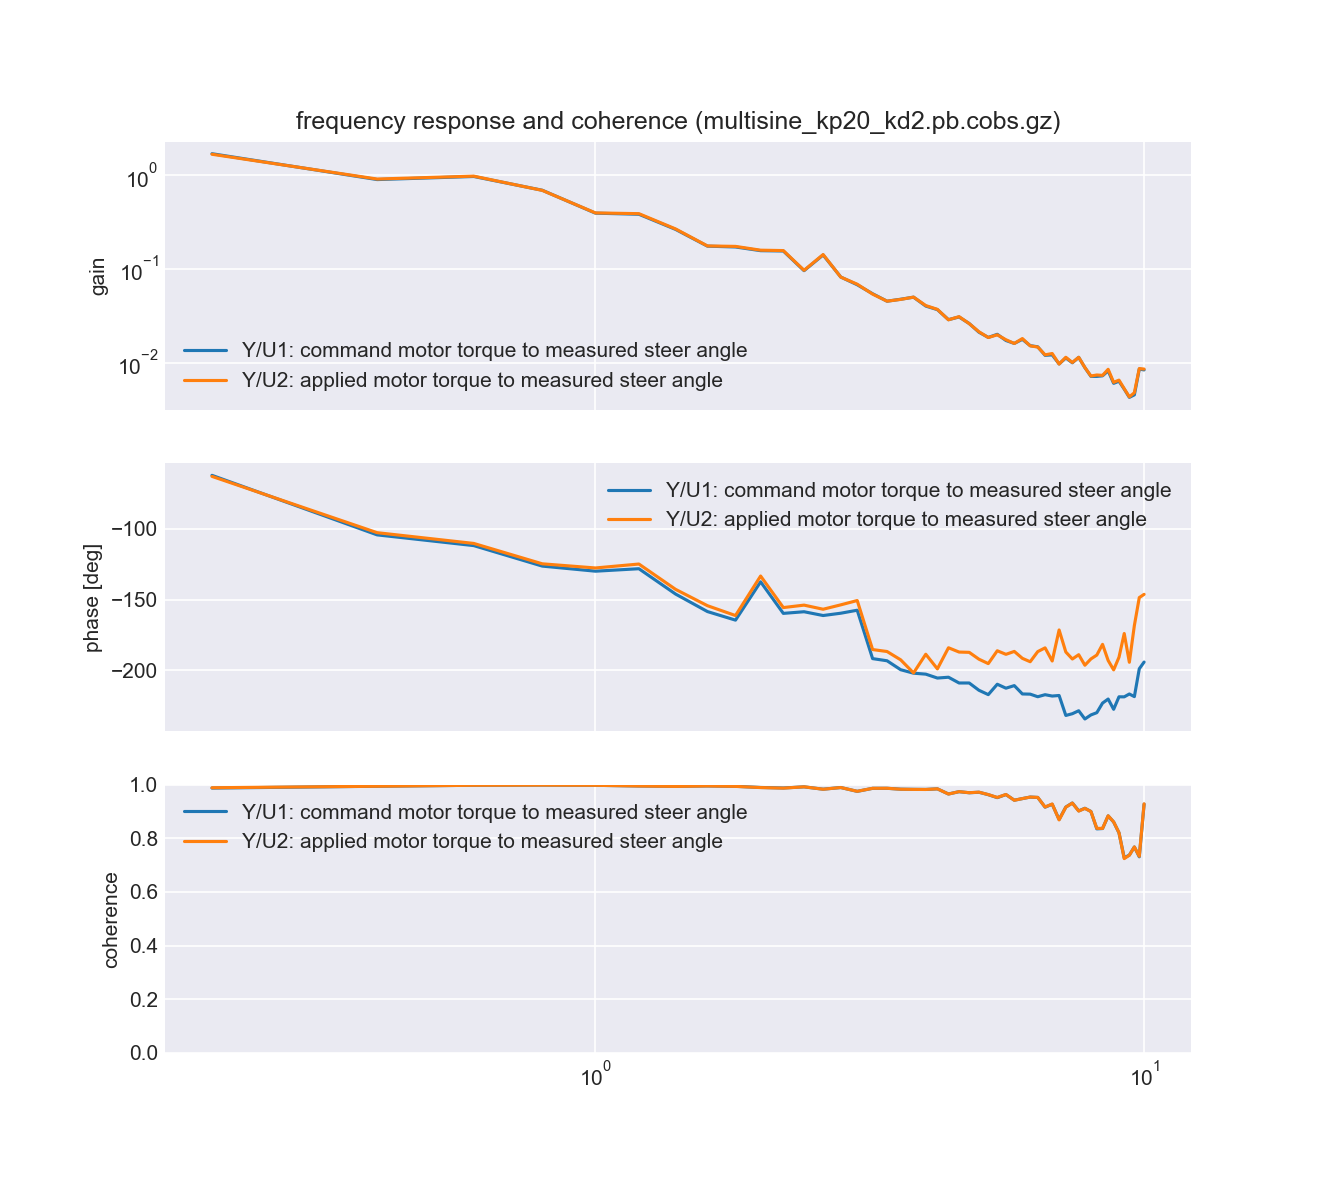

window size: 10000
plotting frequency response using 53 windows with 100 overlap


In [9]:
plt.close('all')
for l in logs[1:]:
    plot_frequency_response(
        l, tfio=[('u1', 'y'), ('u2', 'y')],
        unwrap=True, noverlap=100)
plt.show()

In [145]:
dt = 0.001
u1 = sysid._get_signal(log2, 'u1')[0]
y = sysid._get_signal(log2, 'y')[0]
ddy = scipy.signal.savgol_filter(y, 55, 3, deriv=2, delta=dt)
mwo_data = sysid.iddata(u1, ddy, dt, 'data')

In [146]:
import itertools

# for Box-Jenkins
# y(t) = [B(q)/F(q)] u(t-nk) +  [C(q)/D(q)]e(t)
b = None
a = None
nrmse = -1
#for nb, nc, nd, nf, nk in itertools.product(
#    range(10), range(10), range(10), range(10), range(5)):
for nb, nf in itertools.product(range(15, 20), repeat=2):
    bi, ai, nrmsei = sysid.bj(mwo_data, nb, 0, 0, nf, 0, nrmse=True)
    if nrmsei > nrmse:
        nrmse = nrmsei
        a = ai
        b = bi
        
print(nrmse)
print(b)
print(a)

79.88834827000947
[  2.97726241 -12.33710821  20.46548613 -14.89852692  -2.40875335
  16.30239942 -17.37520778  11.21615254  -8.55997991  11.65445648
 -10.94569588  -0.9999142   15.61668382 -19.13497541  10.97113299
  -1.78890756  -1.85191704   1.52943163  -0.43202894]
[  1.          -5.12014389  10.67148608 -10.54558272   2.23845819
   6.80846262  -9.64631903   7.65068451  -5.67116457   6.0218045
  -6.24203449   1.89327843   5.60357134  -9.21807655   6.59279383
  -2.39638951   0.35917296]


<IPython.core.display.Javascript object>


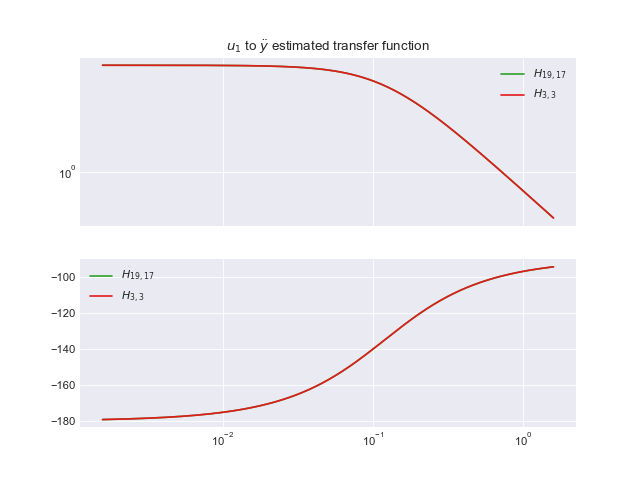

<IPython.core.display.Javascript object>


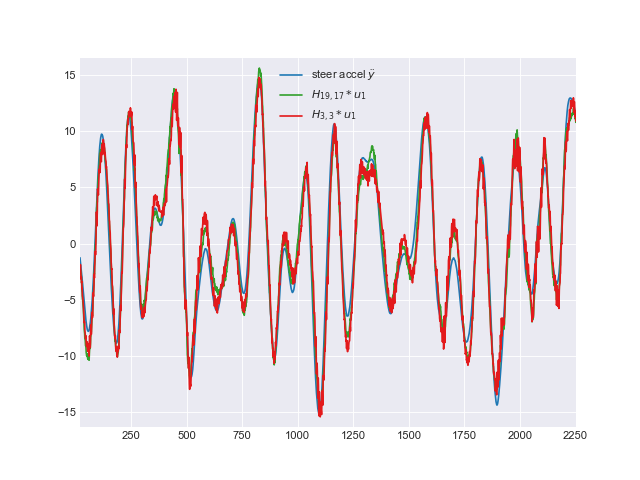

<IPython.core.display.Javascript object>


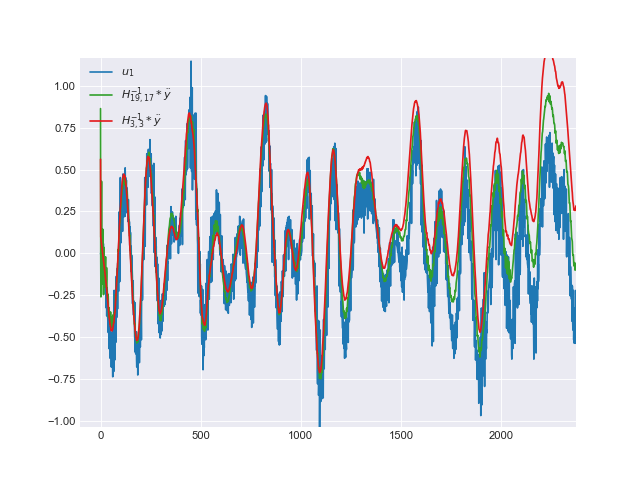

In [147]:
plt.close('all')
color = sns.color_palette('Paired', 10)[1::2]

# plot frequency response plots of Hxx and H33
fig, ax = plt.subplots(2, 1, sharex=True)
b33, a33 = sysid.bj(mwo_data, 3, 0, 0, 3, 0)

wxx, hxx = scipy.signal.freqs(b, a)
w33, h33 = scipy.signal.freqs(b33, a33)

ax[0].loglog(wxx/(2*np.pi), np.abs(h),
             color=color[1],
             label=r'$H_{{{},{}}}$'.format(len(b-1), len(a)))
ax[0].loglog(w33/(2*np.pi), np.abs(h33),
             color=color[2],
             label=r'$H_{3,3}$')

ax[1].semilogx(wxx/(2*np.pi),
               np.unwrap(np.angle(h, deg=True), 180),
               color=color[1],
               label=r'$H_{{{},{}}}$'.format(len(b-1), len(a)))
ax[1].semilogx(w33/(2*np.pi),
               np.unwrap(np.angle(h, deg=True), 180),
               color=color[2],
               label=r'$H_{3,3}$')
ax[0].legend()
ax[1].legend()
ax[0].set_title(r'$u_1$ to $\ddot{y}$ estimated transfer function')

# plot steer acceleration and filtered u1 signals
fig, ax = plt.subplots()
colors = sns.color_palette('Paired', 10)
ax.plot(ddy,
        color=color[0],
        label=r'steer accel $\ddot{y}$')
ax.plot(scipy.signal.lfilter(b, a, u1),
        color=color[1],
        label=r'$H_{{{},{}}}*u_{{1}}$'.format(len(b-1), len(a)))

ax.plot(scipy.signal.lfilter(b33, a33, u1),
        color=color[2],
        label=r'$H_{{{},{}}}*u_{{1}}$'.format(3, 3))
ax.legend()

# plot u1 and steer acceleration with inverse filters
fig, ax = plt.subplots()
colors = sns.color_palette('Paired', 10)
ax.plot(u1,
        color=color[0],
        label=r'$u_{1}$')
ylim = ax.get_ylim()
ax.plot(scipy.signal.lfilter(a, b, ddy),
        color=color[1],
        label=r'$H^{{-1}}_{{{},{}}}*\ddot{{y}}$'.format(len(b-1), len(a)))
ax.plot(scipy.signal.lfilter(a33, b33, ddy),
        color=color[2],
        label=r'$H^{{-1}}_{{{},{}}}*\ddot{{y}}$'.format(3, 3))
ax.set_ylim(ylim)
ax.legend()

plt.show()

In [138]:
dt = 0.001
u2 = sysid._get_signal(log2, 'u2')[0]
y = sysid._get_signal(log2, 'y')[0]
ddy = scipy.signal.savgol_filter(y, 55, 3, deriv=2, delta=dt)
mwo_data = sysid.iddata(u2, ddy, dt, 'data')

In [139]:
import itertools

# for Box-Jenkins
# y(t) = [B(q)/F(q)] u(t-nk) +  [C(q)/D(q)]e(t)
b = None
a = None
nrmse = -1
#for nb, nc, nd, nf, nk in itertools.product(
#    range(10), range(10), range(10), range(10), range(5)):
for nb, nf in itertools.product(range(20), repeat=2):
    bi, ai, nrmsei = sysid.bj(mwo_data, nb, 0, 0, nf, 0, nrmse=True)
    if nrmsei > nrmse:
        nrmse = nrmsei
        a = ai
        b = bi
        
print(nrmse)
print(b)
print(a)

77.89534513664871
[  20.31990342  -85.58021903  167.21323796 -229.80439228  274.48092189
 -301.53632009  310.33369714 -300.92927304  277.30840882 -242.65658864
  201.35943214 -166.94020138  137.53419167 -117.73393483  115.79141977
 -111.1768509    82.94063481  -39.28446542    8.36037161]
[  1.          -3.89676706   6.67110544  -8.12211737   9.63068293
 -10.67878339  10.45825527  -9.98233538   9.35575919  -7.89879399
   6.42988638  -5.56687635   4.50811896  -3.86273879   4.16060847
  -3.79285465   2.26367316  -0.84420733   0.18737571  -0.01998643]


<IPython.core.display.Javascript object>


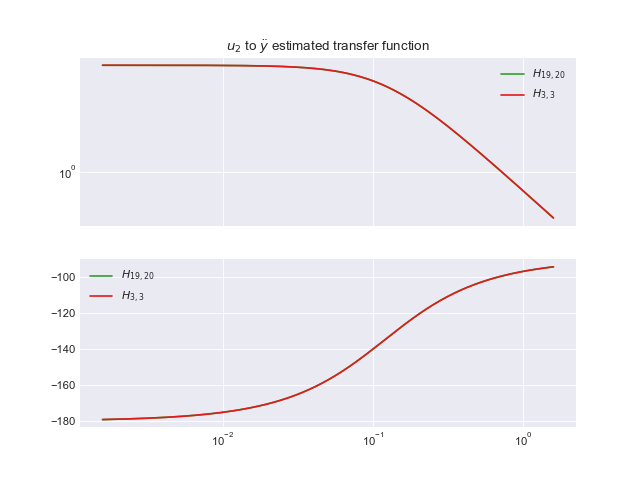

<IPython.core.display.Javascript object>


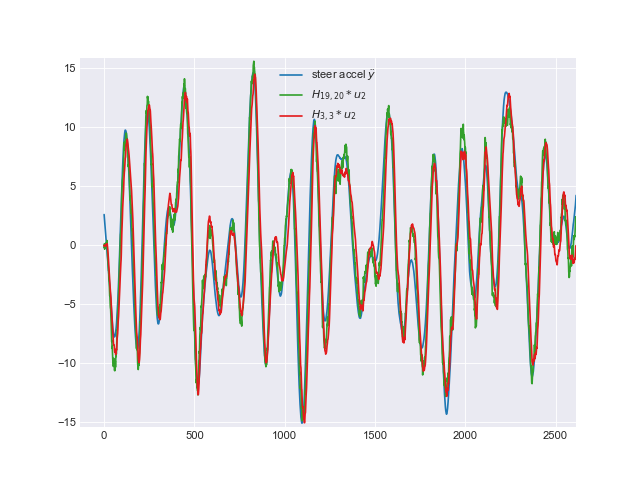

<IPython.core.display.Javascript object>


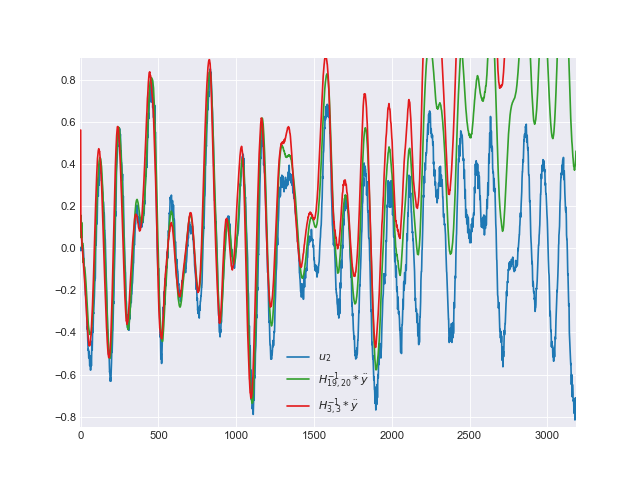

In [141]:
plt.close('all')
color = sns.color_palette('Paired', 10)[1::2]

# plot frequency response plots of Hxx and H33
fig, ax = plt.subplots(2, 1, sharex=True)
b33, a33 = sysid.bj(mwo_data, 3, 0, 0, 3, 0)

wxx, hxx = scipy.signal.freqs(b, a)
w33, h33 = scipy.signal.freqs(b33, a33)

ax[0].loglog(wxx/(2*np.pi), np.abs(h),
             color=color[1],
             label=r'$H_{{{},{}}}$'.format(len(b-1), len(a)))
ax[0].loglog(w33/(2*np.pi), np.abs(h33),
             color=color[2],
             label=r'$H_{3,3}$')

ax[1].semilogx(wxx/(2*np.pi),
               np.unwrap(np.angle(h, deg=True), 180),
               color=color[1],
               label=r'$H_{{{},{}}}$'.format(len(b-1), len(a)))
ax[1].semilogx(w33/(2*np.pi),
               np.unwrap(np.angle(h, deg=True), 180),
               color=color[2],
               label=r'$H_{3,3}$')
ax[0].legend()
ax[1].legend()
ax[0].set_title(r'$u_2$ to $\ddot{y}$ estimated transfer function')

# plot steer acceleration and filtered u2 signals
fig, ax = plt.subplots()
colors = sns.color_palette('Paired', 10)
ax.plot(ddy,
        color=color[0],
        label=r'steer accel $\ddot{y}$')
ax.plot(scipy.signal.lfilter(b, a, u2),
        color=color[1],
        label=r'$H_{{{},{}}}*u_{{2}}$'.format(len(b-1), len(a)))

ax.plot(scipy.signal.lfilter(b33, a33, u2),
        color=color[2],
        label=r'$H_{{{},{}}}*u_{{2}}$'.format(3, 3))
ax.legend()

# plot u2 and steer acceleration with inverse filters
fig, ax = plt.subplots()
colors = sns.color_palette('Paired', 10)
ax.plot(u2,
        color=color[0],
        label=r'$u_{2}$')
ylim = ax.get_ylim()
ax.plot(scipy.signal.lfilter(a, b, ddy),
        color=color[1],
        label=r'$H^{{-1}}_{{{},{}}}*\ddot{{y}}$'.format(len(b-1), len(a)))
ax.plot(scipy.signal.lfilter(a33, b33, ddy),
        color=color[2],
        label=r'$H^{{-1}}_{{{},{}}}*\ddot{{y}}$'.format(3, 3))
ax.set_ylim(ylim)
ax.legend()

plt.show()

In [4]:
# simulation via coprime factorization
dt = 0.001
r = sysid._get_signal(log2, 'r')[0]
u1 = sysid._get_signal(log2, 'u1')[0]
#u2 = sysid._get_signal(log2, 'u2')[0]
y = sysid._get_signal(log2, 'y')[0]
ddy = scipy.signal.savgol_filter(y, 55, 3, deriv=2, delta=dt)
mwo_data1 = sysid.iddata(r, u1, dt, 'data_r_u1')
mwo_data2 = sysid.iddata(r, ddy, dt, 'data_r_ddy')

In [24]:
import itertools

# for ARMAX
# y(t) = [B(q)/A(q)] u(t-nk) +  [C(q)/A(q)]e(t)
# for Box-Jenkins
# y(t) = [B(q)/F(q)] u(t-nk) +  [C(q)/D(q)]e(t)

# R->U1

b1 = None
a1 = None
nrmse = -1
for nb, nf in itertools.product(range(5), repeat=2):
    bi, ai, nrmsei = sysid.bj(mwo_data1, nb, 0, 0, nf, 0, nrmse=True)
    if nrmsei > nrmse:
        nrmse = nrmsei
        a1 = ai
        b1 = bi
        
print(nrmse)
print(b1)
print(a1)

# R->Y/s**2
b2 = None
a2 = None
nrmse = -1
for nb, nf in itertools.product(range(5), repeat=2):
    bi, ai, nrmsei = sysid.bj(mwo_data2, nb, 0, 0, nf, 0, nrmse=True)
    if nrmsei > nrmse:
        nrmse = nrmsei
        a2 = ai
        b2 = bi
        
print(nrmse)
print(b2)
print(a2)

57.61875229292721
[  589.83153235 -1176.69831028   586.87010902]
[ 1.         -1.93700746  1.93061896 -1.93758581  0.95661604]
87.08996860588223
[ 124440.36376197 -368844.01333181  364366.65747854 -119963.01801449]
[ 1.         -0.93891438 -0.98613898  0.93008044]



1.244e+05 z^8 - 6.099e+05 z^7 + 1.319e+06 z^6 - 1.779e+06 z^5 + 1.77e+06 z^4 - 1.29e+06 z^3 + 5.81e+05 z^2 - 1.148e+05 z
------------------------------------------------------------------------------------------------------------------------
                      589.8 z^8 - 2319 z^7 + 4005 z^6 - 4551 z^5 + 3977 z^4 - 2263 z^3 + 561.4 z^2

dt = 0.001



<IPython.core.display.Javascript object>


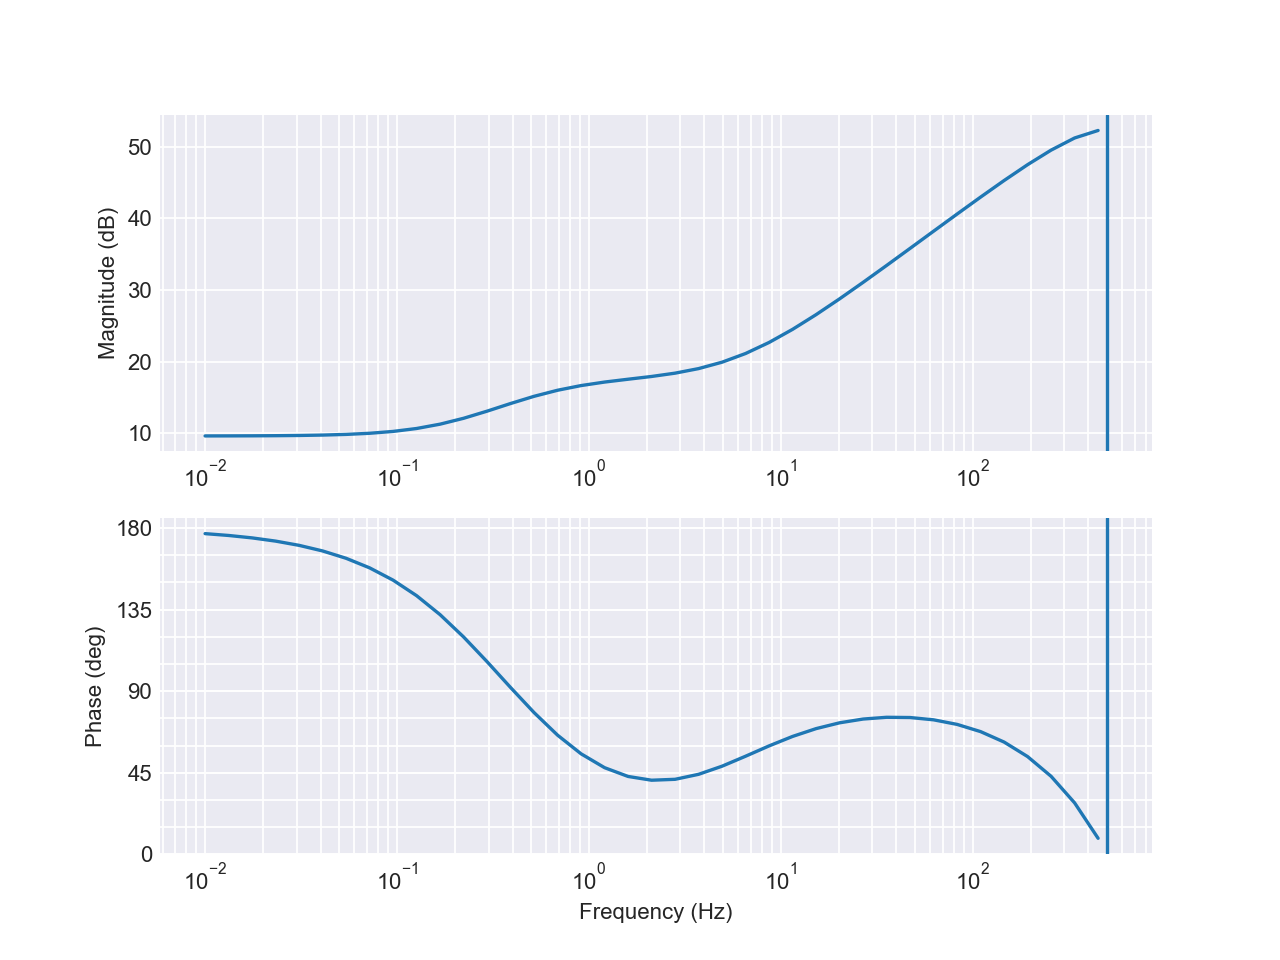

<IPython.core.display.Javascript object>


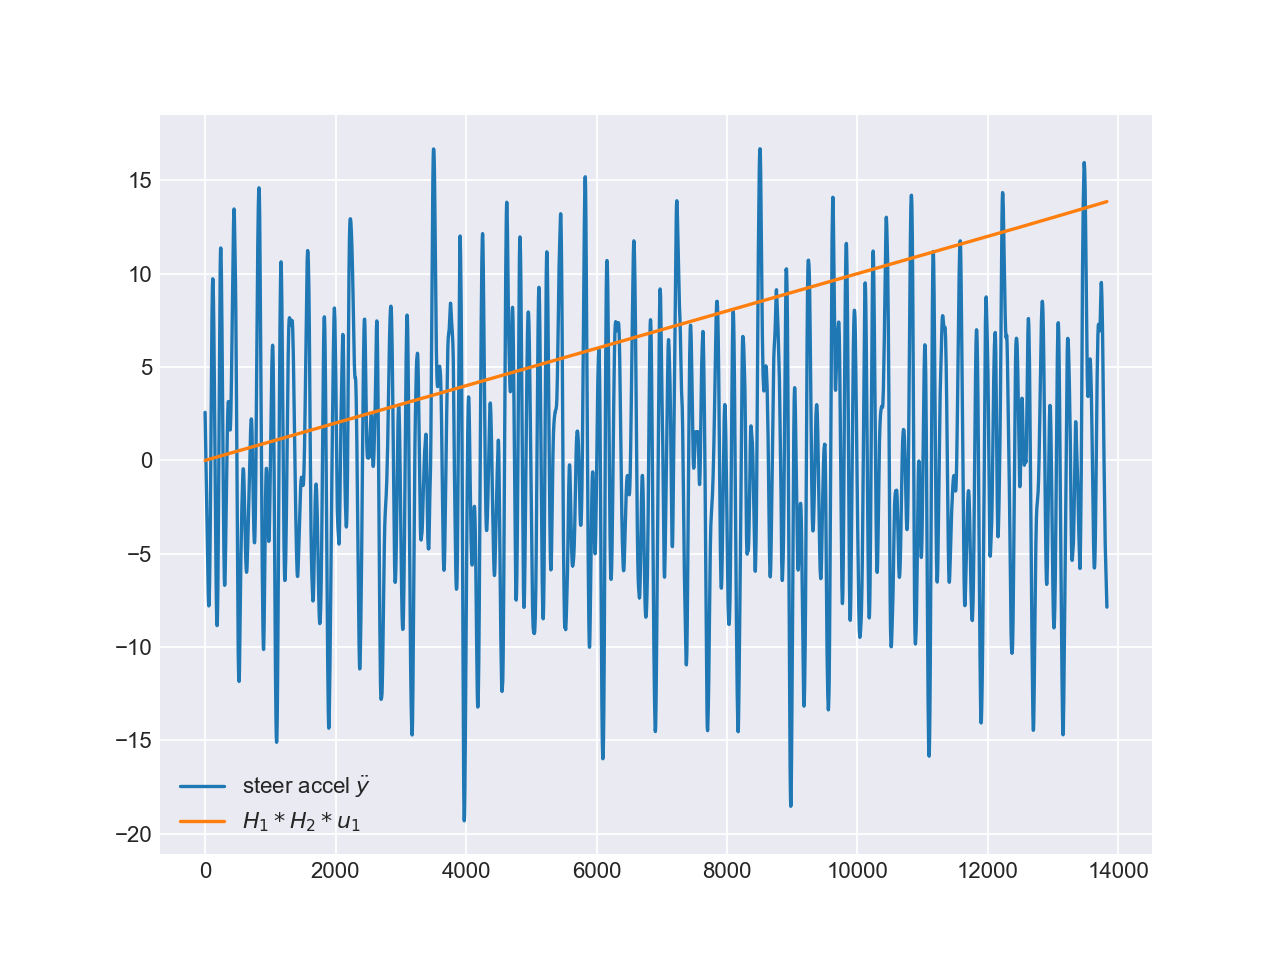

<IPython.core.display.Javascript object>


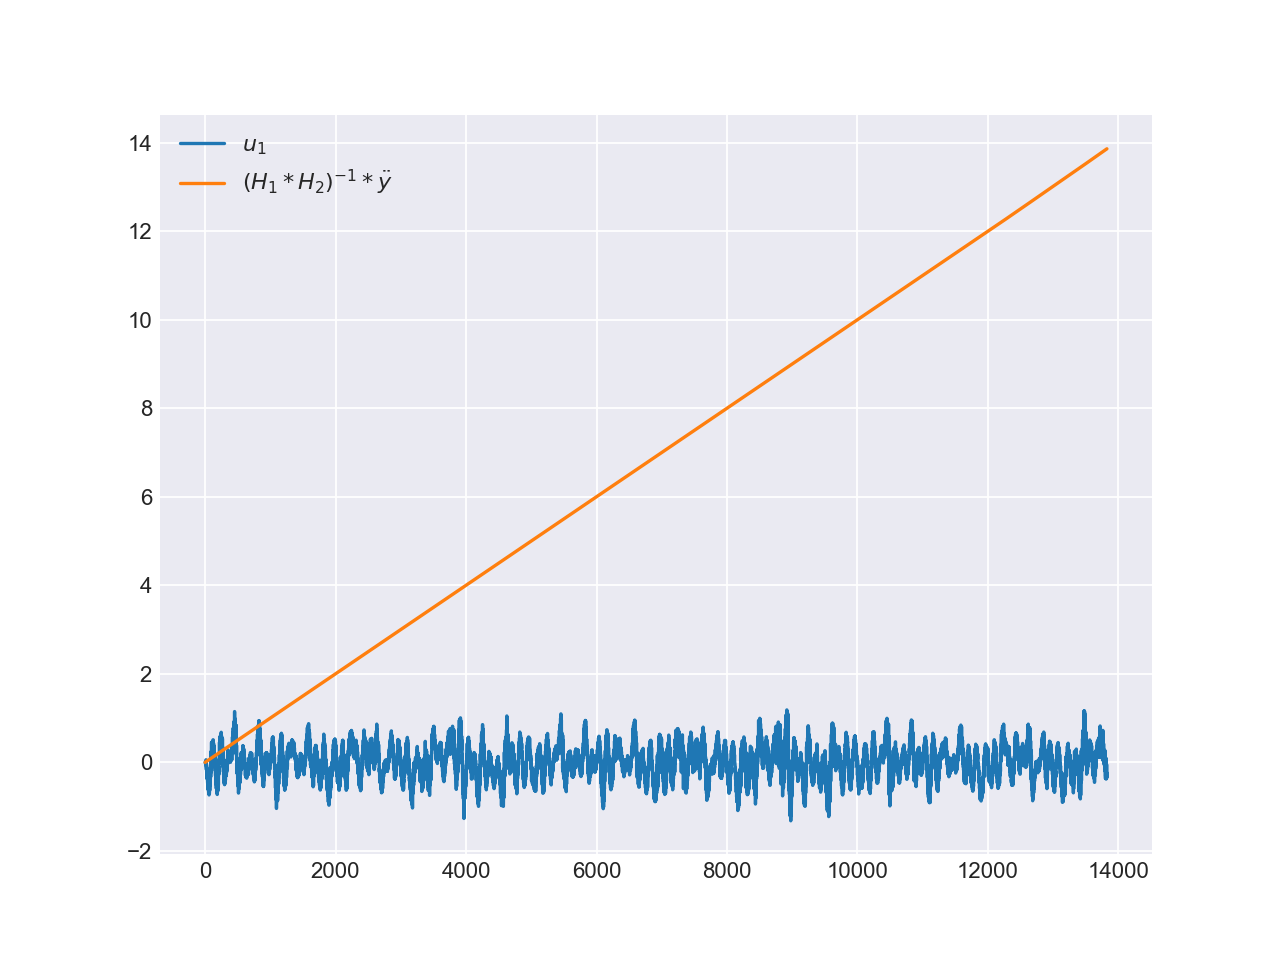

In [25]:
def norm_tf_ba(b, a, dt=None):
    m = max(len(b), len(a))
    _b = np.zeros((m,))
    _a = np.zeros((m,))
    _b[:len(b)] = b
    _a[:len(a)] = a
    return _b, _a

import control
tf_ru1 = control.TransferFunction(*norm_tf_ba(b1, a1), 0.001)
tf_rddy = control.TransferFunction(*norm_tf_ba(b2, a1), 0.001)

H1H2 = tf_rddy/tf_ru1
print(H1H2)

plt.close('all')
mag, phase, omega = control.bode(H1H2)

# plot steer acceleration and filtered u1 signals
fig, ax = plt.subplots()
colors = sns.color_palette('Paired', 10)
ax.plot(ddy,
        label=r'steer accel $\ddot{y}$')
ax.plot(scipy.signal.lsim(
    scipy.signal.TransferFunction(H1H2.num[0][0], H1H2.den[0][0]),
    u1,
    log2.t)[0],
        label=r'$H_1*H_2*u_1$')
ax.legend()

# plot u1 and steer acceleration with inverse filters
fig, ax = plt.subplots()
colors = sns.color_palette('Paired', 10)
ax.plot(u1,
        label=r'$u_{1}$')
ylim = ax.get_ylim()
ax.plot(scipy.signal.lsim(
    scipy.signal.TransferFunction(H1H2.den[0][0], H1H2.num[0][0]),
    u1,
    log2.t)[0],
        label=r'$(H_1*H_2)^{-1}*\ddot{y}$')
ax.legend()
plt.show()